#Imports and Mounting

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/MyDrive/rul/anshul/
%ls

#Parameters and Functions

In [ ]:
#PARAMS
BATCH_SIZE = 32
TIME_STEPS = 8
EPOCHS     = 100
SPLIT      = 0.5
SERIES     = 400

In [ ]:
#FUNCTIONS

def create_sequences(xdat,ydat):
  x=[]
  for i in range(TIME_STEPS,len(xdat)+1):
    x.append(xdat[i-TIME_STEPS:i,:])
  return np.stack(x),ydat[TIME_STEPS-1:,:]

def shuffle_data(xdat,ydat):
  idx = np.random.permutation(len(xdat))
  xdat = xdat[idx]
  ydat = ydat[idx]
  return xdat,ydat

def split_data(xdat,ydat,split=SPLIT):
  limit = int(len(xdat)*(1-split))
  return xdat[:limit,:,:],ydat[:limit,:],xdat[limit:,:,:],ydat[limit:,:]

def mish(x):
  return tf.multiply(tf.activations.tanh(tf.activations.softplus(x)),x)



#Data Frame

In [ ]:
y_df = pd.read_csv('discharge_2.csv').drop(['datetime','cycle','ambient_temperature'],axis=1)
y_df['capacity'] = ( y_df['capacity'] - y_df['capacity'].min()  ) / ( y_df['capacity'].max() - y_df['capacity'].min() )
y_df

,capacity
0,1.000000
1,0.982145
2,0.962852
3,0.962700
4,0.961616
...,...
163,0.010564
164,0.000968
165,0.000000
166,0.037894


In [ ]:
cycle_df = pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1)

for col in ( ['voltage_measured',	'current_measured',	'temperature_measured',	'current_load',	'voltage_load' ] ):
  #cycle_df[col] = ( cycle_df[col] - cycle_df[col].mean() ) /  cycle_df[col].std()
  cycle_df[col] = ( cycle_df[col] - cycle_df[col].min()  ) / ( cycle_df[col].max() - cycle_df[col].min() )
#cycle_df = cycle_df.drop(['current_measured','current_load',	'voltage_load'],axis=1)
cycle_df = cycle_df.drop(['current_load',	'voltage_load'],axis=1)
cycle_df['cycle'] = cycle_df['cycle'] - 1
cycle_df

,cycle,voltage_measured,current_measured,temperature_measured
0,0,0.982216,0.993912,0.061157
1,0,0.981796,0.995594,0.060936
2,0,0.859640,0.008136,0.064396
3,0,0.846539,0.007424,0.072932
4,0,0.836713,0.008816,0.083167
...,...,...,...,...
50280,167,0.635784,0.995549,0.638867
50281,167,0.637313,0.994813,0.636123
50282,167,0.638738,0.994807,0.628527
50283,167,0.640352,0.996918,0.622457


#AutoFeature

In [ ]:
latent_features = 8
FEATURES        = 5
act             ='swish'

In [ ]:
inp = keras.layers.Input((400,FEATURES))

conv = keras.layers.Conv1D(8,3,activation=act)(inp)
conv = keras.layers.Conv1D(8,3,activation=act)(conv)
conv = keras.layers.Conv1D(8,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(16,4,activation=act)(conv)
conv = keras.layers.Conv1D(16,3,activation=act)(conv)
conv = keras.layers.Conv1D(16,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(32,4,activation=act)(conv)
conv = keras.layers.Conv1D(32,3,activation=act)(conv)
conv = keras.layers.Conv1D(32,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(64,3,activation=act)(conv)
conv = keras.layers.Conv1D(64,3,activation=act)(conv)
conv = keras.layers.Conv1D(64,3,activation=act)(conv)

conv = keras.layers.MaxPooling1D(2)(conv)

conv = keras.layers.Conv1D(128,3,activation=act)(conv)
conv = keras.layers.Conv1D(128,3,activation=act)(conv)
conv = keras.layers.Conv1D(128,3,activation=act)(conv)

gap = keras.layers.GlobalMaxPooling1D()(conv)

out = keras.layers.Dense(latent_features)(gap)

SeriesEncoder = keras.models.Model(inputs=inp,outputs=out)
SeriesEncoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 5)]          0         
                                                                 
 conv1d (Conv1D)             (None, 398, 8)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 396, 8)            200       
                                                                 
 conv1d_2 (Conv1D)           (None, 394, 8)            200       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 197, 8)           0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 194, 16)           528       
                                                             

In [ ]:
SeriesEncoder.load_weights('SeriesEncoder.h5')

In [ ]:
exinp_df = pd.read_csv('discharge.csv').drop(['datetime','time','capacity','ambient_temperature'],axis=1)

for col in ( ['voltage_measured',	'current_measured',	'temperature_measured',	'current_load',	'voltage_load' ] ):
  #cycle_df[col] = ( cycle_df[col] - cycle_df[col].mean() ) /  cycle_df[col].std()
  exinp_df[col] = ( exinp_df[col] - exinp_df[col].min()  ) / ( exinp_df[col].max() - exinp_df[col].min() )
#cycle_df = cycle_df.drop(['current_measured','current_load',	'voltage_load'],axis=1)
#exinp_df = exinp_df.drop(['current_measured','current_load',	'voltage_load'],axis=1)
exinp_df['cycle'] = exinp_df['cycle'] - 1
exinp_df

,cycle,voltage_measured,current_measured,temperature_measured,current_load,voltage_load
0,0,0.982216,0.993912,0.061157,0.49985,0.000000
1,0,0.981796,0.995594,0.060936,0.49985,0.992449
2,0,0.859640,0.008136,0.064396,0.00005,0.722511
3,0,0.846539,0.007424,0.072932,0.00005,0.714960
4,0,0.836713,0.008816,0.083167,0.00005,0.710477
...,...,...,...,...,...,...
50280,167,0.635784,0.995549,0.638867,0.50015,0.000000
50281,167,0.637313,0.994813,0.636123,0.50015,0.000000
50282,167,0.638738,0.994807,0.628527,0.50015,0.000000
50283,167,0.640352,0.996918,0.622457,0.50015,0.000000


In [ ]:
pre_x_dat = []
for i in range(0,168):
  temp = exinp_df.loc[cycle_df['cycle'] == i]
  temp = temp.to_numpy()[:,1:]
  temp = np.vstack( [ temp, np.zeros((SERIES-temp.shape[0],temp.shape[1])) ] )
  pre_x_dat.append(temp)


print(min(pre_x_dat, key = lambda k: len(k)).shape)
print(max(pre_x_dat, key = lambda k: len(k)).shape)
pre_x_dat = np.array(pre_x_dat)
pre_x_dat.shape

(400, 5)
(400, 5)


(168, 400, 5)

In [ ]:
extracted_x_dat = SeriesEncoder(pre_x_dat,training=False)
extracted_x_dat = pd.DataFrame(extracted_x_dat.numpy())
extracted_x_dat = ( extracted_x_dat - extracted_x_dat.min() ) / ( extracted_x_dat.max() - extracted_x_dat.min() + 10e-10 )
extracted_x_dat

,0,1,2,3,4,5,6,7
0,0.041652,0.051647,0.870643,0.055971,0.825871,0.948599,0.951593,0.917133
1,0.000000,0.125457,0.827862,0.066962,0.999854,0.960135,0.998114,0.918322
2,0.013637,0.234153,0.825819,0.030599,0.993684,0.934177,0.975363,0.903742
3,0.064621,0.250569,0.857817,0.023087,0.995484,0.940656,0.977423,0.935335
4,0.063655,0.246163,0.856101,0.024645,0.994528,0.940093,0.977660,0.936888
...,...,...,...,...,...,...,...,...
163,0.702715,0.202244,0.431821,0.312557,0.217391,0.483674,0.050585,0.220797
164,0.681019,0.254401,0.513459,0.305953,0.150307,0.456447,0.042614,0.255847
165,0.680040,0.250233,0.514426,0.306702,0.142988,0.457455,0.046388,0.257387
166,0.779173,0.140494,0.485942,0.258750,0.167818,0.529104,0.110900,0.293298


#Data Preprocess

In [ ]:
x_dat = extracted_x_dat.to_numpy()
#x_dat = pd.concat([extracted_x_dat, cycle_df.groupby('cycle').mean()], axis=1).to_numpy()
#x_dat = cycle_df.groupby('cycle').mean().to_numpy()

y_dat = y_df.to_numpy()
print(x_dat.shape,y_dat.shape)
x_dat, y_dat = create_sequences(x_dat,y_dat)
x_train, y_train, x_test, y_test = split_data(x_dat,y_dat)
x_eval = x_dat
y_eval = y_dat
print(x_dat.shape,y_dat.shape)
print([each.shape for each in [x_train, y_train, x_test, y_test]])

(168, 8) (168, 1)
(161, 8, 8) (161, 1)
[(80, 8, 8), (80, 1), (81, 8, 8), (81, 1)]


#ResNet-50

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 8, 16)]      0           []                               
                                                                                                  
 conv1 (Conv1D)                 (None, 8, 16)        272         ['input_7[0][0]']                
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 8, 16)        64          ['conv1[0][0]']                  
                                                                                                  
 activation_25 (Activation)     (None, 8, 16)        0           ['bn_conv1[0][0]']               
                                                                                           

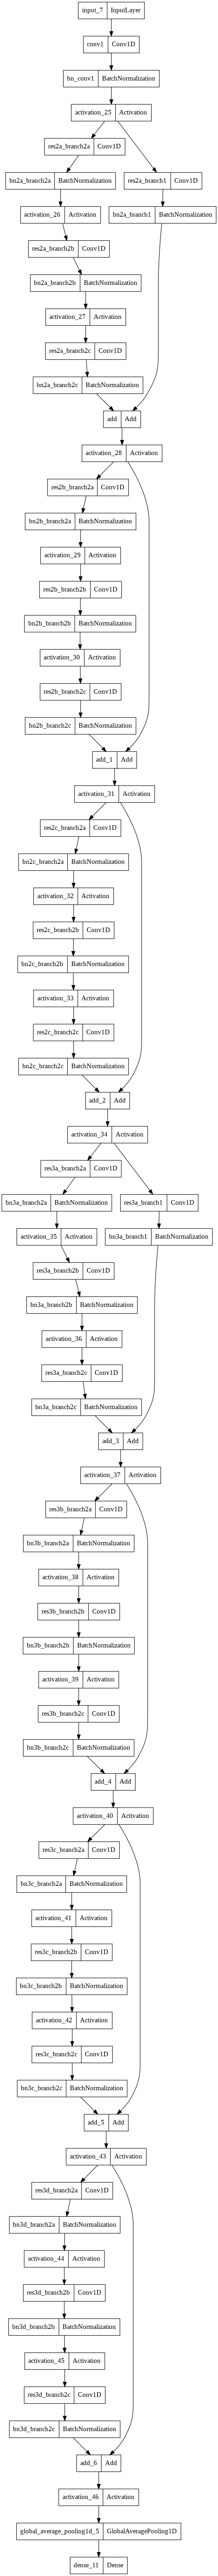

In [ ]:
kr = keras.regularizers.l2(0.001)
act = 'swish'

def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = keras.layers.Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X = keras.layers.Add()([X, X_shortcut])# SKIP Connection
    X = keras.layers.Activation(act)(X)

    return X

def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = keras.layers.Conv1D(filters=F1, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '2a', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = keras.layers.Activation(act)(X)

    X = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X)
    X = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X_shortcut = keras.layers.Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X_shortcut)
    X_shortcut = keras.layers.BatchNormalization(axis=2, name=bn_name_base + '1')(X_shortcut)

    X = keras.layers.Add()([X, X_shortcut])
    X = keras.layers.Activation(act)(X)

    return X


def ResNet50(input_shape=x_train[0].shape):

    X_input = keras.layers.Input(input_shape)

    X = keras.layers.Conv1D(16, 1, strides=1, name='conv1', kernel_initializer=keras.initializers.glorot_uniform(seed=0),kernel_regularizer=kr)(X_input)
    X = keras.layers.BatchNormalization(axis=2, name='bn_conv1')(X)
    X = keras.layers.Activation(act)(X)

    X = convolutional_block(X, f=3, filters=[32, 32, 64], stage=2, block='a', s=1)
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='b')
    X = identity_block(X, 3, [32, 32, 64], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[64, 64, 128], stage=3, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='b')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='c')
    X = identity_block(X, 3, [64, 64, 128], stage=3, block='d')


    X = keras.layers.GlobalAveragePooling1D()(X)
    out = keras.layers.Dense(1)(X)
    
    model = keras.models.Model(inputs=X_input, outputs=out, name='ResNet50')

    return model

model = ResNet50()
model.summary()
keras.utils.plot_model(model)

In [ ]:
#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Adam( learning_rate = 0.001, decay = 10e-5 )
metrics = [
           'mae',
           'mape',
]

model.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN

hist = model.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*10,
                  validation_data = ( x_test , y_test ),
                  batch_size = None,
                 )

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_df.to_numpy()
y_eval = y_df.to_numpy()

x_eval = ( x_eval - np.amin(x_eval,axis=0) ) / ( np.amax(x_eval,axis=0) - np.amin(x_eval,axis=0) + 10e-10)
y_eval = ( y_eval - np.amin(y_eval,axis=0) ) / ( np.amax(y_eval,axis=0) - np.amin(y_eval,axis=0) + 10e-10)

x_eval, y_eval = create_sequences(x_eval,y_eval)


In [ ]:
plt.plot(model.predict(x_eval))
plt.plot(y_eval)
plt.show()

#The Neuron

In [ ]:
kr  = keras.regularizers.L2(0.0001)
kr2 = keras.regularizers.L2(0.0001)
kr3 = keras.regularizers.L2(0.0001)
act = None

inp  = keras.layers.Input(x_train[0].shape)
flat = keras.layers.Flatten()(inp)
dense = keras.layers.Dense(32,activation=act,kernel_regularizer=kr3)(flat)
dense = keras.layers.Dense(16,kernel_regularizer=kr2)(dense)
dense = keras.layers.Dense(4,kernel_regularizer=kr)(dense)
out  = keras.layers.Dense(1)(dense)

TheNeuron = keras.models.Model(inputs=inp,outputs=out)
TheNeuron.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 8, 8)]            0         
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 4)                 68        
                                                                 
 dense_13 (Dense)            (None, 1)                 5         
                                                                 
Total params: 2,681
Trainable params: 2,681
Non-trainable p

In [ ]:

#COMPILE

loss = [
        #'mse'
        #tf.keras.losses.MeanSquaredLogarithmicError()
        #tf.keras.losses.LogCosh()
        tf.keras.losses.Huber()
      ]
optimizer = keras.optimizers.Nadam( learning_rate = 0.001, decay=10e-6 )
metrics = [
           'mae',
           'mape',
]

TheNeuron.compile(loss = loss,optimizer=optimizer,metrics=metrics)

In [ ]:
#RUN
callbacks=[
           #keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.7,patience=5, min_lr=0.0001),
           keras.callbacks.EarlyStopping(monitor='val_mae', patience=1000, restore_best_weights=True)
]

hist = TheNeuron.fit(
                  x_train,
                  y_train,
                  epochs = EPOCHS*50,
                  validation_data = ( x_test , y_test ),
                  callbacks=callbacks
                 )

Epoch 1/5000
3/3 [==============================] - 2s 115ms/step - loss: 0.4374 - mae: 0.8975 - mape: 122.9028 - val_loss: 0.0608 - val_mae: 0.2715 - val_mape: 2506178.2500
Epoch 2/5000
3/3 [==============================] - 0s 22ms/step - loss: 0.1497 - mae: 0.4703 - mape: 66.2055 - val_loss: 0.0394 - val_mae: 0.2306 - val_mape: 5244149.0000
Epoch 3/5000
3/3 [==============================] - 0s 20ms/step - loss: 0.0571 - mae: 0.2713 - mape: 36.6304 - val_loss: 0.0517 - val_mae: 0.2381 - val_mape: 6871426.5000
Epoch 4/5000
3/3 [==============================] - 0s 30ms/step - loss: 0.0316 - mae: 0.1822 - mape: 22.4764 - val_loss: 0.0652 - val_mae: 0.2632 - val_mape: 7619233.0000
Epoch 5/5000
3/3 [==============================] - 0s 22ms/step - loss: 0.0235 - mae: 0.1537 - mape: 19.6468 - val_loss: 0.0685 - val_mae: 0.2739 - val_mape: 7702999.0000
Epoch 6/5000
3/3 [==============================] - 0s 28ms/step - loss: 0.0185 - mae: 0.1248 - mape: 16.9475 - val_loss: 0.0718 - val_mae

KeyboardInterrupt: ignored

In [ ]:
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
x_eval = x_dat
y_eval = y_dat


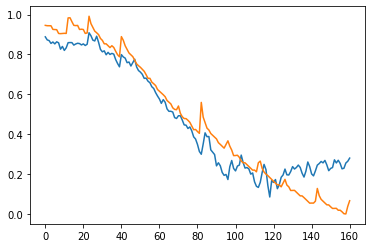

In [ ]:
plt.plot(TheNeuron.predict(x_eval))
plt.plot(y_eval)
plt.show()

#Correlation Test

In [ ]:
cor = pd.concat([extracted_x_dat, y_df], axis=1)
cor.corr()

,0,1,2,3,4,5,6,7,capacity
0,1.000000,0.112543,-0.802430,0.692788,-0.796863,-0.872424,-0.932068,-0.920334,-0.548100
1,0.112543,1.000000,0.153998,0.472210,0.135434,-0.305190,0.073571,-0.169109,0.477633
2,-0.802430,0.153998,1.000000,-0.450142,0.736608,0.785627,0.874047,0.814272,0.641826
3,0.692788,0.472210,-0.450142,1.000000,-0.429095,-0.820905,-0.562062,-0.813069,0.162534
4,-0.796863,0.135434,0.736608,-0.429095,1.000000,0.640871,0.897908,0.750322,0.719457
5,-0.872424,-0.305190,0.785627,-0.820905,0.640871,1.000000,0.814025,0.938364,0.257849
6,-0.932068,0.073571,0.874047,-0.562062,0.897908,0.814025,1.000000,0.892192,0.707204
7,-0.920334,-0.169109,0.814272,-0.813069,0.750322,0.938364,0.892192,1.000000,0.389354
capacity,-0.548100,0.477633,0.641826,0.162534,0.719457,0.257849,0.707204,0.389354,1.000000


In [ ]:
cor = pd.concat([cycle_df, y_df], axis=1)
cor.corr()

,cycle,voltage_measured,current_measured,temperature_measured,capacity
cycle,1.000000,-0.132877,0.127769,0.139936,NaN
voltage_measured,-0.132877,1.000000,-0.091667,-0.914580,0.940539
current_measured,0.127769,-0.091667,1.000000,0.354628,0.160740
temperature_measured,0.139936,-0.914580,0.354628,1.000000,-0.942558
capacity,NaN,0.940539,0.160740,-0.942558,1.000000


In [ ]:
cor = pd.concat([extracted_x_dat,cycle_df, y_df], axis=1)
cor.corr()

,0,1,2,3,4,5,6,7,cycle,voltage_measured,current_measured,temperature_measured,capacity
0,1.000000,0.112543,-0.802430,0.692788,-0.796863,-0.872424,-0.932068,-0.920334,NaN,-0.686948,-0.253037,0.709661,-0.548100
1,0.112543,1.000000,0.153998,0.472210,0.135434,-0.305190,0.073571,-0.169109,NaN,0.320455,-0.143690,-0.331657,0.477633
2,-0.802430,0.153998,1.000000,-0.450142,0.736608,0.785627,0.874047,0.814272,NaN,0.690054,0.176452,-0.706242,0.641826
3,0.692788,0.472210,-0.450142,1.000000,-0.429095,-0.820905,-0.562062,-0.813069,NaN,-0.052171,-0.138999,0.090291,0.162534
4,-0.796863,0.135434,0.736608,-0.429095,1.000000,0.640871,0.897908,0.750322,NaN,0.815472,0.233444,-0.846033,0.719457
5,-0.872424,-0.305190,0.785627,-0.820905,0.640871,1.000000,0.814025,0.938364,NaN,0.421361,0.209323,-0.442681,0.257849
6,-0.932068,0.073571,0.874047,-0.562062,0.897908,0.814025,1.000000,0.892192,NaN,0.806114,0.230010,-0.834163,0.707204
7,-0.920334,-0.169109,0.814272,-0.813069,0.750322,0.938364,0.892192,1.000000,NaN,0.546629,0.213269,-0.578006,0.389354
cycle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.132877,0.127769,0.139936,NaN
voltage_measured,-0.686948,0.320455,0.690054,-0.052171,0.815472,0.421361,0.806114,0.546629,-0.132877,1.000000,-0.091667,-0.914580,0.940539


In [ ]:
print(extracted_x_dat.head(0))
extracted_x_dat = extracted_x_dat.drop([1,2,3,4,5,6,7],axis=1)
extracted_x_dat

Empty DataFrame
Columns: [0, 1, 2, 3, 4, 5, 6, 7]
Index: []


,0
0,0.041652
1,0.000000
2,0.013637
3,0.064621
4,0.063655
...,...
163,0.702715
164,0.681019
165,0.680040
166,0.779173


#Mods